## UN_SW_15 Anomaly Detection using Unsupervised Approaches

### 1. Import and Setup

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Modeling methods and selection
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

# Anomaly detection methods
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor

# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve, average_precision_score, roc_curve

# Visualization
import matplotlib.pyplot as plt
import openpyxl


In [2]:
#train_path = 'UNSW-NB15 dataset/CSV Files/Training and Testing Sets/UNSW_NB15_training-set.csv'
#test_path  = 'UNSW-NB15 dataset/CSV Files/Training and Testing Sets/UNSW_NB15_testing-set.csv'

### 2. Projecting the data

In [3]:
# Load your dataset
df = pd.read_csv('UNSW-NB15 dataset/CSV Files/Training and Testing Sets/UNSW_NB15_training-set.csv', header =0, index_col=0)
print('Available columns:', df.columns.tolist())
df.head()

Available columns: ['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label']


,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
id,,,,,,,,,,,,,,,,,,,,,
1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,0,0,0,1,1,0,Normal,0
2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,2,0,0,0,1,6,0,Normal,0
3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,3,0,0,0,2,6,0,Normal,0
4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,3,1,1,0,2,1,0,Normal,0
5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,1,40,0,0,0,2,39,0,Normal,0


In [4]:
df.columns

Index(['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

In [5]:
n_observations = df.shape[0]
print(f"Number of observations: {n_observations}")

NaN= df.isnull().sum().sum()  # Check for missing values in the dataset
print(f"Number of missing values: {NaN}")

anom =  df.label == 1
# Automatically detect the label column (update as needed)
print("No. of Attacks/Anomalies:", df[anom].label.size)
print("No. of Normal Observations:", df[~anom].label.size)

Number of observations: 175341
Number of missing values: 0
No. of Attacks/Anomalies: 119341
No. of Normal Observations: 56000


## 3) Defining loading and manipulating the data

In [6]:
def load_agg_data(data_dir='./UNSW-NB15 dataset/CSV Files/',
	cat_reduce = True,
	drop_cols=['srcip', 'sport', 'dstip', 'dsport','stcpb','dtcpb','ltime', 'stime']):
	'''
    Load data found in full UNSW-NB15 .csv files into a Pandas DataFrame.
    Expects individual .csv files to have name 'UNSW-NB15_{}.csv'
    ---
    Input:
        data_dir: string, path to directory holding the UNSW-NB15 .csv files.
        cat_reduce: bool, reduce categorical columns to only a select group of
           entries. Defaults to True.
        drop_cols: list, columns to drop from the original data. Defauls to a
            pre_determined list of columns that are not informative in a 
            modeling context.
    Returns:
        Pandas DataFrame with NaN values imputed, categories reduced if 
        desired, and columns dropped as specified.
	'''
	dfs = []
	for i in range(1,5):
		path = data_dir + 'UNSW-NB15_{}.csv'
		dfs.append(pd.read_csv(path.format(i), header=None))

	all_data = pd.concat(dfs).reset_index(drop=True)
	all_data.columns = pd.read_csv(
    './UNSW-NB15 dataset/CSV Files/NUSW-NB15_features.csv',
	encoding='latin1'
	).Name.apply(lambda x: x.lower())


	## Column cleaning steps: some of the CSV's leave the point blank for zero values.
	## This results in Pandas loading in NaN values in columns where it otherwise expects numeric values. 
	# Fill all NaN attack categories w/ value: 'normal'
	all_data['attack_cat'] = all_data.attack_cat.fillna(value='normal').apply(lambda x: x.strip().lower())
	all_data['attack_cat'] = all_data.attack_cat.replace(value='backdoors', to_replace='backdoor')
	# Replace blank spaces with zero
	all_data['ct_ftp_cmd'] = all_data.ct_ftp_cmd.replace(to_replace=' ', value=0).astype(int)
	# Replace NaN with zero
	all_data['ct_flw_http_mthd'] = all_data.ct_flw_http_mthd.fillna(value=0)
	# Replace NaN with zero and all values > 0 with 1
	all_data['is_ftp_login'] = (all_data.is_ftp_login.fillna(value=0) >0).astype(int)

	## Reduce categorical features into smaller sets:
	## Ex: 135 unique values in `proto` become "tcp", "udp", "arp", "unas", and "other"
	transformations = {
	    'proto':['tcp', 'udp', 'arp', 'unas'],
	    'state':['fin', 'con', 'int'],
	    'service':['-', 'dns']
	}
	if cat_reduce == True:
		for col, keepers in transformations.items():
			all_data[col] = all_data[col].apply(reduce_column,
	    		args=(keepers,))

	# Return with non-informative data eliminated
	drop_cols = ['srcip', 'sport', 'dstip', 'dsport','stcpb',
	    'dtcpb','ltime', 'stime']
	if drop_cols:
		return all_data.drop(columns=drop_cols)
	else:
		return all_data

def load_agg_Xy(path='./UNSW-NB15 dataset/CSV Files/', sample_size=0.25, strat_cat='label',
	    rnd_state=None):
	'''
	Wrapper function for loading smaller subset of the full UNSW-NB15
	dataset. Calls `load_agg_data` and 
	---
	Inputs:

	'''

	df = load_agg_data(data_dir=path)
	_, X, _, y = train_test_split(df.iloc[:,:-2],df[strat_cat],
		stratify=df[strat_cat], test_size=sample_size,
		random_state=rnd_state)
	return X.reset_index(drop=True), y.reset_index(drop=True)


def load_csv_data(path, strategy='basic', to_exclude='object'):
	"""
	Wrapper function for loading data from a provided csv.
	Assumes the csv has a header row and an index column when
	creating the dataframe to return.
	"""

	data = pd.read_csv(path,header=0, index_col=0)

	features = data.select_dtypes(exclude='object').iloc[:,:-1]

	if strategy == 'basic':
		# Drop all columns of a certain type, in this case non-numeric.
		# Return features and class labels as separate objects
		return features, data.label

	elif strategy == 'anomaly':
		return features, data.label.apply(y_anomaly_format)

def y_anomaly_format(y):
    '''
    Accepts a target value of 0 or 1 and reformats to the appropriate class for sklearn's anomaly models.
    inlier: 0 -> 1
    outlier: 1 -> -1
    '''
    if y == 0:
        return 1
    elif y == 1:
        return -1
    else:
        print('Unexpected input:', y)
        raise ValueError ('Unexpected input')

def reduce_column(s, to_keep):
    '''
    Reduces the string values found in a column
    to the values provided in the list 'to_keep'.
    ---
    Input:
        s: string
        to_keep: list of strings
    Returns:
        string, s if s should be kept, else 'other'
    '''
    s = s.lower().strip()
    if s not in to_keep:
        return 'other'
    else:
        return s

def reject_outliers(data, m=5):
    '''
    Accepts a 2D Numpy array.
    Returns the indices rows with all values less than m times larger than the mean for that column.
    Effectively: returns indices for rows without outlier data.
    '''
    array_bools = abs(data - np.mean(data, axis=0)) < m * np.std(data, axis=0)
    indexes_not_outliers = np.apply_along_axis(all,1,array_bools)
    return indexes_not_outliers

attack_to_num = {
	'normal':0,
	'analysis':1,
	'backdoors':2,
	'dos':3,
	'exploits':4,
	'fuzzers':5,
	'generic':6,
	'reconnaissance':7,
	'shellcode':8,
	'worms':9
}

In [7]:
# Load train and test data
X_train, y_train = load_agg_Xy(path='./UNSW-NB15 dataset/CSV Files/', sample_size=0.1, strat_cat='label')

# Reformat for anomaly detection labeling
y_train = y_train.apply(y_anomaly_format)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19200\2034430839.py:22: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(path.format(i), header=None))
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19200\2034430839.py:22: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(path.format(i), header=None))


In [8]:
# Heuristic: treat 'object' columns as categorical; others numeric.
X_train, X_hold, y_train, y_hold  = train_test_split(X_train,y_train, test_size = 0.25,
                                                     random_state = 42, stratify=y_train)

In [9]:
X_train.shape, X_hold.shape

((190503, 39), (63502, 39))

In [10]:
train_normal = y_train==1

## 4) Preprocessing transformer (scaler+OHE)

In [11]:
## Bring in column transformations to process contextual features and standardize numerical values
# with open('ct_ohe_ssc_xyagg.pkl', 'rb') as f:
#    col_trans = pkl.load(f)

# Define the individual steps
ohe_step = ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
ssc_step = ('std_sclr', StandardScaler())

# Make the step part of a pipeline
ohe_pipe = Pipeline([ohe_step])
ssc_pipe = Pipeline([ssc_step])

# Columns to transform: categorical columns for encoding, numeric feature columns for standardizing
ohe_cols = ['proto', 'state', 'service']
binary_cols = ['is_sm_ips_ports', 'is_ftp_login']
non_ssc_cols = ohe_cols+binary_cols
ssc_cols = [col for col in X_train.columns if col not in non_ssc_cols]

# Transformer input: tuple w/ contents ('name', SomeTransformer(Parameters), columns)
transformer = [
    ('one_hot_encoding', ohe_pipe, ohe_cols),
    ('standard_scaling', ssc_pipe, ssc_cols)
]
col_trans = ColumnTransformer(transformers=transformer, remainder='passthrough')

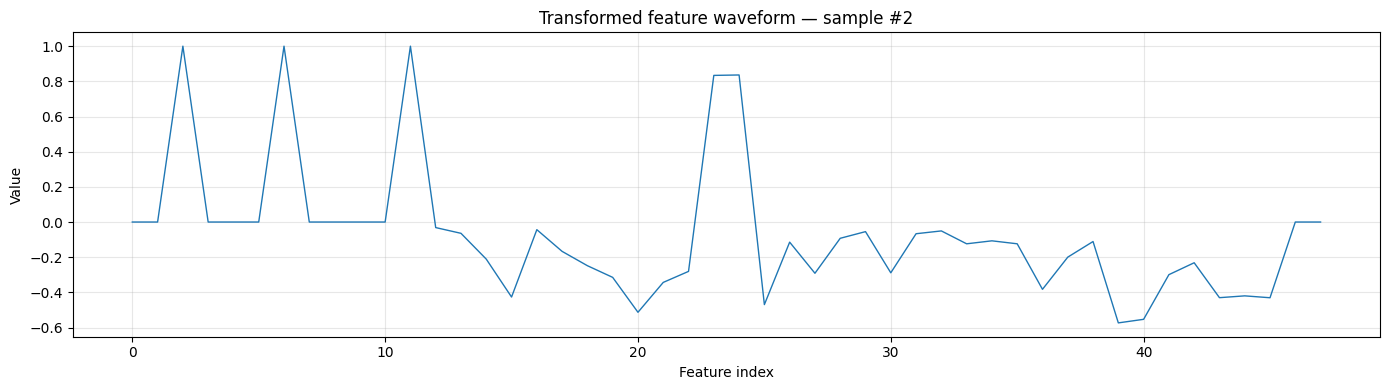

In [12]:
X_tr = col_trans.fit_transform(X_train)

# 2) Grab feature names for axes (works in sklearn >= 1.0)
try:
    feat_names = col_trans.get_feature_names_out()
except AttributeError:
    # Fallback if using older sklearn
    feat_names = [f"f{i}" for i in range(X_tr.shape[1])]

# 3) Pick a single sample (change idx as you like)
idx = 2  # or: np.random.randint(len(X_train))
wave = X_tr[idx]

# 4) Plot the full waveform (may be wide if many features)
plt.figure(figsize=(14, 4))
plt.plot(wave, linewidth=1)
plt.title(f"Transformed feature waveform — sample #{idx}")
plt.xlabel("Feature index")
plt.ylabel("Value")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5) Unsupervised anomaly detectors 

### 5.1 Isolation Forest

In [13]:
iso = IsolationForest(random_state=0)
iso.fit(col_trans.fit_transform(X_train[train_normal]))

IsolationForest(random_state=0)

In [14]:
y_if_train = iso.predict(col_trans.transform(X_train))
y_if_hold = iso.predict(col_trans.transform(X_hold))

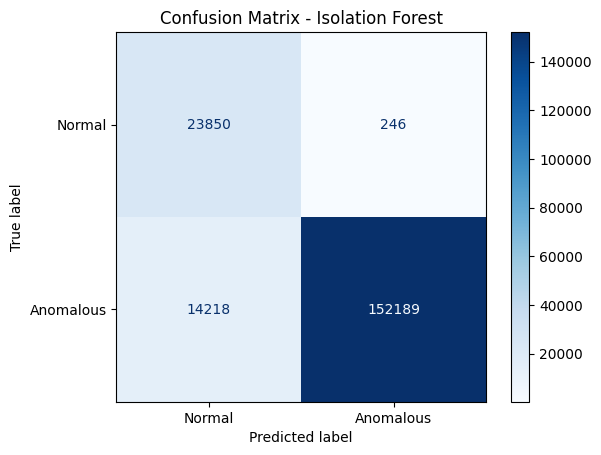

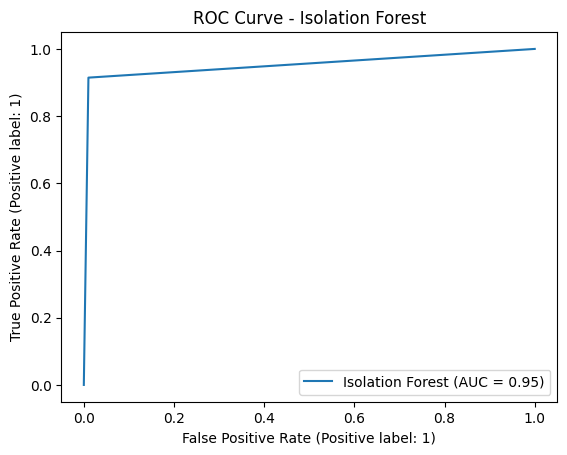

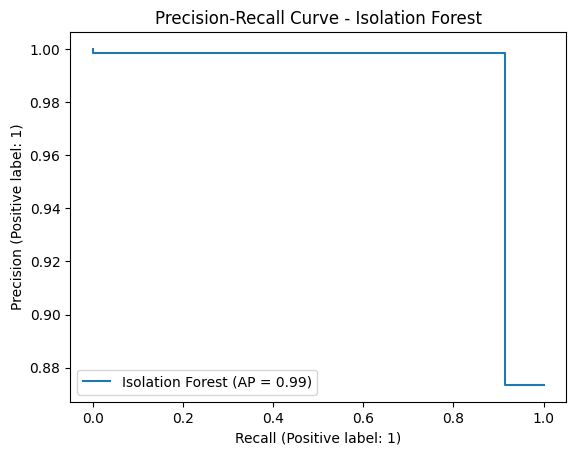

In [15]:
# The true outliers are in the top row and the true inliers in the second.
# We want the diagonal values to be as high as possible.
cm = confusion_matrix(y_train, y_if_train)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomalous"])
cm_display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Isolation Forest")

roc_display = RocCurveDisplay.from_predictions(y_train, y_if_train, name="Isolation Forest")
plt.title("ROC Curve - Isolation Forest")

pr_display = PrecisionRecallDisplay.from_predictions(y_train, y_if_train, name="Isolation Forest")
plt.title("Precision-Recall Curve - Isolation Forest")

plt.show()

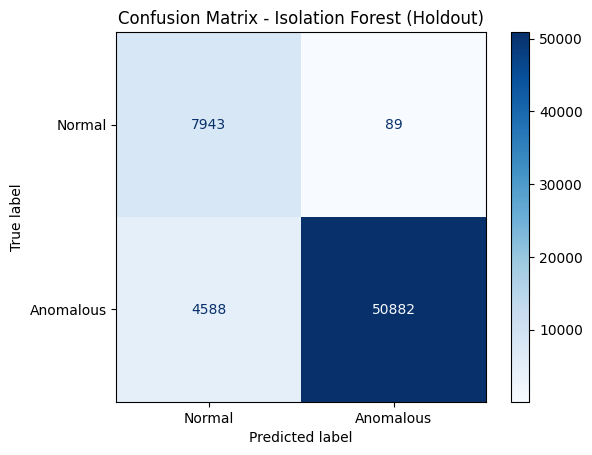

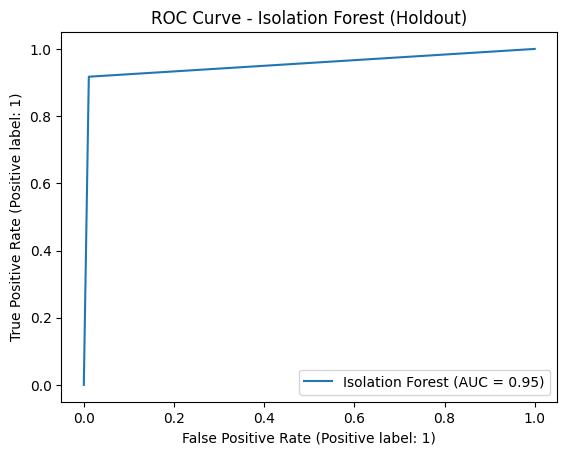

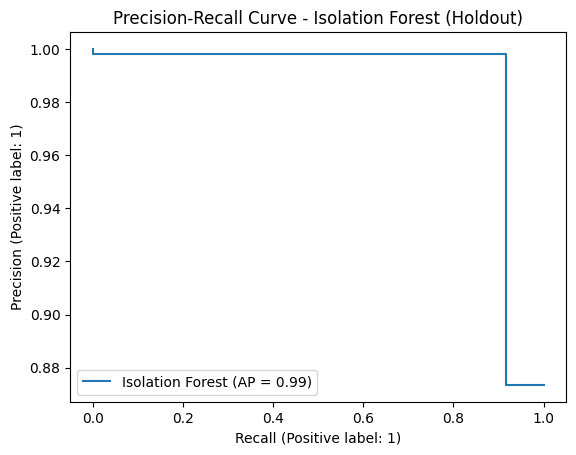

Classification Report 
               precision    recall  f1-score   support

      Normal     0.6339    0.9889    0.7726      8032
   Anomalous     0.9983    0.9173    0.9561     55470

    accuracy                         0.9263     63502
   macro avg     0.8161    0.9531    0.8643     63502
weighted avg     0.9522    0.9263    0.9328     63502

ROC-AUC Score 0.9531039735954326


In [16]:
cm = confusion_matrix(y_hold, y_if_hold)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomalous"])
cm_display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Isolation Forest (Holdout)")

roc_display = RocCurveDisplay.from_predictions(y_hold, y_if_hold, name="Isolation Forest")
plt.title("ROC Curve - Isolation Forest (Holdout)")

pr_display = PrecisionRecallDisplay.from_predictions(y_hold, y_if_hold, name="Isolation Forest")
plt.title("Precision-Recall Curve - Isolation Forest (Holdout)")

plt.show()
print(f'Classification Report \n {classification_report(y_hold, y_if_hold, target_names=["Normal", "Anomalous"], digits=4)}')
print('ROC-AUC Score', roc_auc_score(y_hold, y_if_hold))

### 5.2 Basic One Class SVM

In [17]:
ocsvm = OneClassSVM(kernel='rbf',gamma='scale', nu=0.05)
ocsvm.fit(col_trans.transform(X_train[train_normal]))

OneClassSVM(nu=0.05)

In [18]:
y_ocsvm_nm = ocsvm.fit_predict(col_trans.transform(X_train[train_normal]))
y_ocsvm_out = ocsvm.predict(col_trans.transform(X_train[~train_normal]))
y_ocsvm_train = ocsvm.predict(col_trans.transform(X_train))
y_ocsvm_hold = ocsvm.predict(col_trans.transform(X_hold))

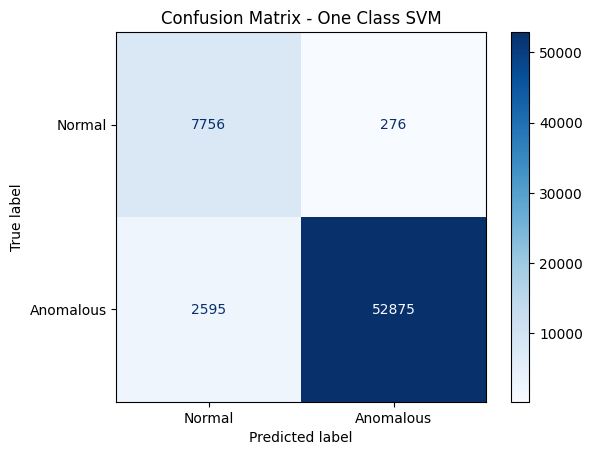

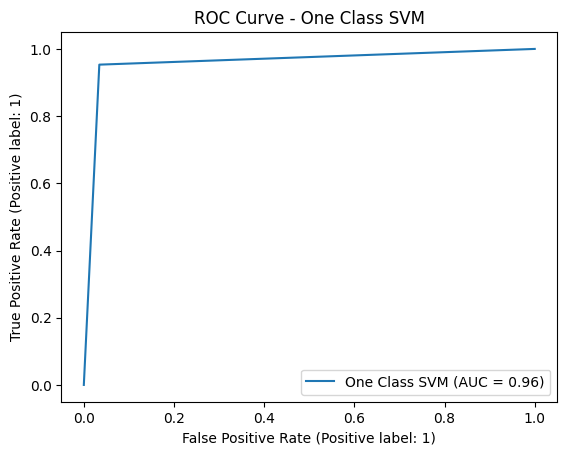

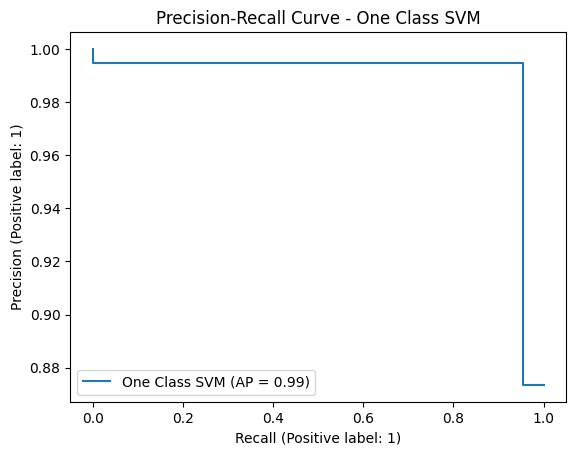

Classification Report 
               precision    recall  f1-score   support

      Normal     0.7493    0.9656    0.8438      8032
   Anomalous     0.9948    0.9532    0.9736     55470

    accuracy                         0.9548     63502
   macro avg     0.8721    0.9594    0.9087     63502
weighted avg     0.9638    0.9548    0.9572     63502

ROC-AUC Score 0.9594277029254534


In [19]:
cm = confusion_matrix(y_hold, y_ocsvm_hold)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomalous"])
cm_display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - One Class SVM")

roc_display = RocCurveDisplay.from_predictions(y_hold, y_ocsvm_hold, name="One Class SVM")
plt.title("ROC Curve - One Class SVM")

pr_display = PrecisionRecallDisplay.from_predictions(y_hold, y_ocsvm_hold, name="One Class SVM")
plt.title("Precision-Recall Curve - One Class SVM")

plt.show()

print(f'Classification Report \n {classification_report(y_hold, y_ocsvm_hold, target_names=["Normal", "Anomalous"], digits=4)}')
print('ROC-AUC Score', roc_auc_score(y_hold, y_ocsvm_hold))

### 5.3 Elliptical Envelope

In [20]:
X_train_t = col_trans.transform(X_train[train_normal])
X_hold_t = col_trans.transform(X_hold)

pca = PCA(n_components=20, random_state=42)
X_train_pca = pca.fit_transform(X_train_t)
X_hold_pca = pca.transform(X_hold_t)

eenv = EllipticEnvelope(contamination=0.1, support_fraction=0.8, random_state=42)
eenv.fit(X_train_pca)

y_pred_hold = eenv.predict(X_hold_pca)


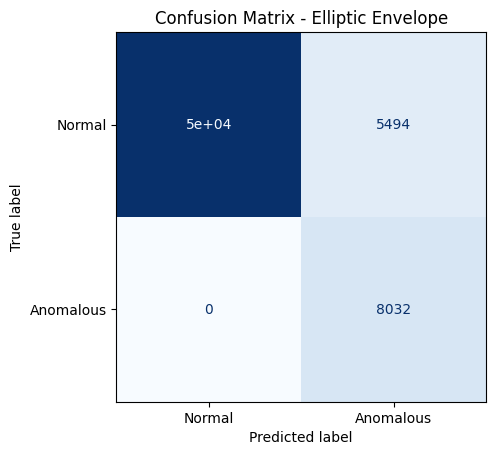

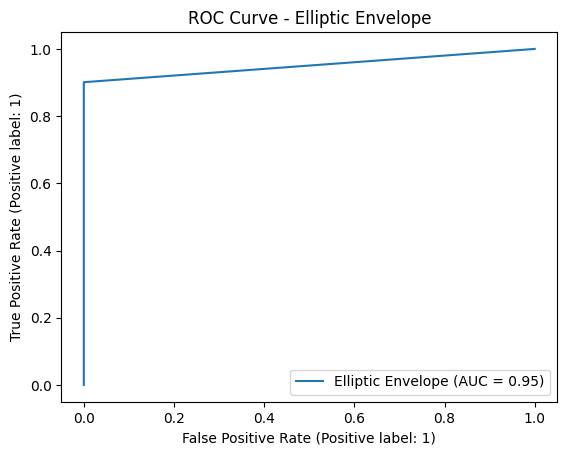

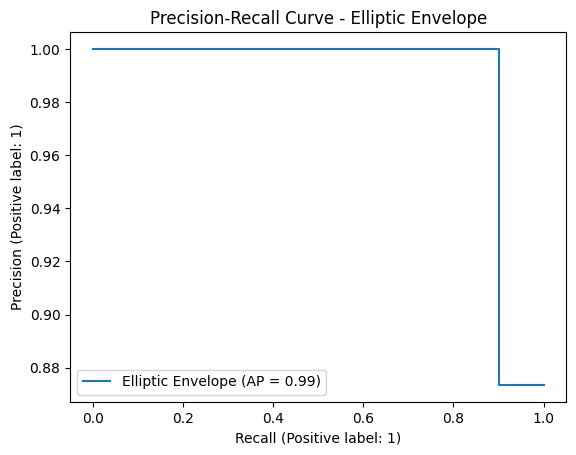

Classification Report 
               precision    recall  f1-score   support

      Normal     0.5938    1.0000    0.7452      8032
   Anomalous     1.0000    0.9010    0.9479     55470

    accuracy                         0.9135     63502
   macro avg     0.7969    0.9505    0.8465     63502
weighted avg     0.9486    0.9135    0.9223     63502

ROC-AUC 0.9504777357129981


In [21]:
cm = confusion_matrix(y_hold, y_pred_hold, labels=[1, -1])
cm_display = ConfusionMatrixDisplay(cm, display_labels=["Normal", "Anomalous"])
cm_display.plot(cmap=plt.cm.Blues, colorbar=False)
plt.title("Confusion Matrix - Elliptic Envelope")

roc_display = RocCurveDisplay.from_predictions(y_hold, y_pred_hold, name="Elliptic Envelope")
plt.title("ROC Curve - Elliptic Envelope")

pr_display = PrecisionRecallDisplay.from_predictions(y_hold, y_pred_hold, name="Elliptic Envelope")
plt.title("Precision-Recall Curve - Elliptic Envelope")

plt.show()

print(f'Classification Report \n {classification_report(y_hold, y_pred_hold, target_names=["Normal", "Anomalous"], digits=4)}')
print("ROC-AUC",roc_auc_score(y_hold, y_pred_hold))

### 5.4 Local Outlier Factor 

In [22]:
X_train_t = col_trans.transform(X_train)
X_hold_t = col_trans.transform(X_hold)

rus = RandomUnderSampler(random_state=42)
X_bal, y_bal = rus.fit_resample(X_train_t, y_train)

lof = LocalOutlierFactor(n_neighbors=35, contamination=0.10, novelty=True, metric='euclidean')
#y_pred = lof.fit_predict(col_trans.transform(X_train_res))
lof.fit(X_bal[y_bal==1])

y_pred_train = lof.predict(X_train_t)
y_pred_hold = lof.predict(X_hold_t)

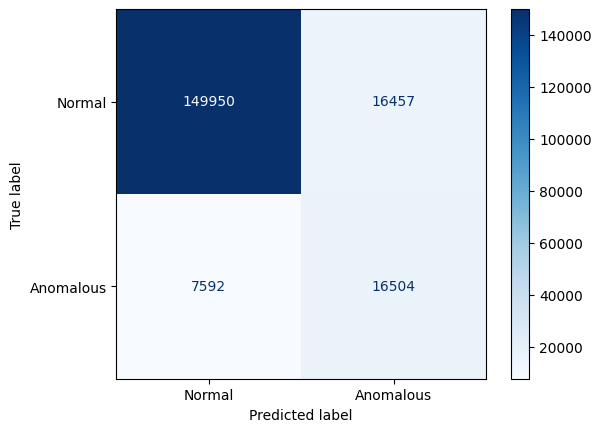

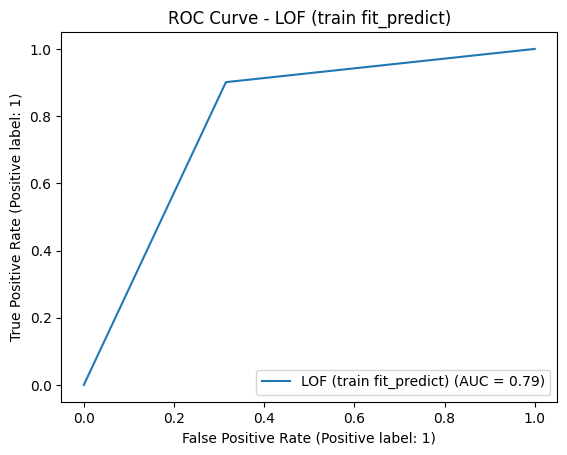

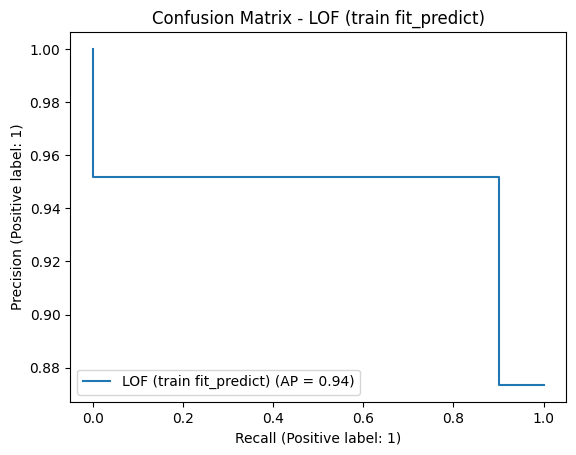

[[ 16504   7592]
 [ 16457 149950]]
Classification Report 
               precision    recall  f1-score   support

      Normal     0.5007    0.6849    0.5785     24096
   Anomalous     0.9518    0.9011    0.9258    166407

    accuracy                         0.8738    190503
   macro avg     0.7263    0.7930    0.7521    190503
weighted avg     0.8948    0.8738    0.8818    190503

ROC AUC Score: 0.7930154393692784


In [23]:
cm_lof_tr = confusion_matrix(y_train, y_pred_train, labels=[1, -1])
ConfusionMatrixDisplay(confusion_matrix=cm_lof_tr, display_labels=["Normal", "Anomalous"]).plot(cmap=plt.cm.Blues)

RocCurveDisplay.from_predictions(y_train, y_pred_train, name="LOF (train fit_predict)")
plt.title("ROC Curve - LOF (train fit_predict)")

PrecisionRecallDisplay.from_predictions(y_train, y_pred_train, name="LOF (train fit_predict)")
plt.title("Precision-Recall Curve - LOF (train fit_predict)")

plt.title("Confusion Matrix - LOF (train fit_predict)")
plt.show()

print(confusion_matrix(y_train, y_pred_train))

print(f'Classification Report \n {classification_report(y_train, y_pred_train, target_names=["Normal", "Anomalous"], digits=4)}')
print(f'ROC AUC Score: {roc_auc_score(y_train, y_pred_train)}')

In [24]:
neg_scores = lof.negative_outlier_factor_
out_scores = (neg_scores.max()-neg_scores)/(neg_scores.max()-neg_scores.min())

In [25]:
pd.Series(neg_scores).describe()

count    24096.000000
mean        -1.165203
std          0.618971
min        -19.374093
25%         -1.149042
50%         -1.054021
75%         -1.006955
max         -0.943237
dtype: float64

In [26]:


def evaluate_and_store(model_name, y_true, y_pred, results_list):
    report = classification_report(
        y_true, y_pred,
        target_names=['Normal','Anomalous'],
        output_dict=True,  # returns a dict, not a string
        zero_division=0
    )
    auc = roc_auc_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=[1,-1])
    
    results_list.append({
        "Model": model_name,
        "Accuracy": report["accuracy"],
        "Normal_Precision": report["Normal"]["precision"],
        "Normal_Recall": report["Normal"]["recall"],
        "Normal_F1": report["Normal"]["f1-score"],
        "Anomaly_Precision": report["Anomalous"]["precision"],
        "Anomaly_Recall": report["Anomalous"]["recall"],
        "Anomaly_F1": report["Anomalous"]["f1-score"],
        "Macro_F1": report["macro avg"]["f1-score"],
        "Weighted_F1": report["weighted avg"]["f1-score"],
        "ROC_AUC": auc,
        "Confusion_Matrix": cm.tolist()
    })


# 1) Collect results
results = []

# Example: LOF
evaluate_and_store("LocalOutlierFactor", y_train, y_pred_train, results)

# Example: IsolationForest
evaluate_and_store("IsolationForest", y_hold, y_if_hold, results)

# Example: EllipticEnvelope (PCA)
evaluate_and_store("EllipticEnvelope_PCA", y_hold, y_pred_hold, results)

# Example: OneClassSVM
evaluate_and_store("OneClassSVM", y_hold, y_ocsvm_hold, results)

# 2) Convert to DataFrame
df_results = pd.DataFrame(results)

# 3) Export
df_results.to_csv("model_results.csv", index=False)
df_results.to_excel("model_results.xlsx", index=False)

print("Exported results to model_results.csv and model_results.xlsx")

Exported results to model_results.csv and model_results.xlsx


## Generation of .pt and pickle files

In [27]:
import pickle as pkl

# Save the trained One-Class SVM model
with open('ocsvm.pkl', 'wb') as f:
    pkl.dump(ocsvm, f)
print("Saved One-Class SVM model to ocsvm.pkl")

# Save the ColumnTransformer
with open('column_transformer.pkl', 'wb') as f:
    pkl.dump(col_trans, f)
print("Saved ColumnTransformer to column_transformer.pkl")

# Save the Isolation Forest model
with open('isolation_forest.pkl', 'wb') as f:
    pkl.dump(iso, f)
print("Saved Isolation Forest model to isolation_forest.pkl")

# Save the local outlier factor model
with open('lof.pkl', 'wb') as f:
    pkl.dump(lof, f)
print("Saved Local Outlier Factor model to local_outlier_factor.pkl")

# Save the trained elliptic envelope model
with open('elliptic_envelope.pkl', 'wb') as f:
    pkl.dump(eenv, f)
print("Saved Elliptic Envelope model to elliptic_envelope.pkl")

# Save the trained elliptic envelope_pca model
with open('elliptic_pca.pkl', 'wb') as f: 
    pkl.dump(pca, f)
print("Saved Elliptic Envelope model to elliptic_envelope_pca.pkl")

Saved One-Class SVM model to ocsvm.pkl
Saved ColumnTransformer to column_transformer.pkl
Saved Isolation Forest model to isolation_forest.pkl
Saved Local Outlier Factor model to local_outlier_factor.pkl
Saved Elliptic Envelope model to elliptic_envelope.pkl
Saved Elliptic Envelope model to elliptic_envelope_pca.pkl
